In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
from copy import deepcopy
from typing import Any

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

from acnportal.acnsim.network.sites import caltech_acn, jpl_acn

from sustaingym.envs.evcharging.actions import to_schedule, ACTION_DISCRETIZATION_FACTOR
from sustaingym.envs.evcharging.ev_charging import EVChargingEnv

MIN_ACTION = 0
MAX_ACTION = 4


In [3]:
# Initialize gym
env = EVChargingEnv(
    site='caltech',
    date_range=["2018-11-07", "2018-11-12"],
    real_traces=False,
    sequential=True, # doesn't matter if real traces is False
    n_components=50,
    action_type='discrete',
)

observation = env.reset()

rewards = 0
done = False
i = 0
action = np.ones(shape=(54,), ) * 2
while not done:
    observation, reward, done, info = env.step(action)

    rewards += reward
    i += 1

print()
print()
print("total iterations: ", i)
print("total reward: ", rewards)

env.close()
print(env.max_timestamp)


--- Training GMMs ---

Fetching data from site caltech for date range 2018-11-07 2018-11-12... 
Fitting GMMs (50 components, 4 dimensions)... 
Creating directory:  sustaingym/envs/evcharging/gmms/caltech/2018-11-07 2018-11-12 50
Saving in:  sustaingym/envs/evcharging/gmms/caltech/2018-11-07 2018-11-12 50

GMM training complete. 



total iterations:  176
total reward:  -760.9350042586698
288


In [3]:

# r = cp.Variable(54, integer=True)

# acn = caltech_acn()
# A = acn.constraint_matrix
# phase_factor = np.exp(1j * np.deg2rad(observation['phases']))
# A_tilde = A * phase_factor[None, :]
# agg_current_complex = A_tilde @ r
# agg_magnitude = cp.abs(agg_current_complex)

# demands = cp.Parameter(54)

# objective = cp.Minimize(cp.norm(r - demands, p=1))
# constraints = [0 <= r, r <= MAX_ACTION, agg_magnitude <= observation['magnitudes'] / 8]

# prob = cp.Problem(objective, constraints)
# print("Is DPP? ", prob.is_dcp(dpp=True))
# print("Is DCP? ", prob.is_dcp(dpp=False))

# demand_vals = [np.random.rand(54) * i for i in range(10)]
# i = 0
# for demand in demand_vals:
#     i += 1
#     print(i)
#     demands.value = demand
#     prob.solve(solver='ECOS_BB')



# # print("Optimal value", prob.solve(solver='ECOS_BB'))
# # print("Optimal var")
# # print(r.value)

In [6]:
from typing import Any

from sustaingym.envs.evcharging.actions import to_schedule, ACTION_DISCRETIZATION_FACTOR
from copy import deepcopy

MIN_ACTION = 0
MAX_ACTION = 4


class BaseOnlineAlgorithm:
    """
    Abstract base class meant to be inherited from to implement new algorithms.

    Subclasses must implement the schedule method.

    Attributes:
        env: EV Charging Environment
    """
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        TODO comments
        Create a schedule of charging rates for each ev in the active_evs list.
        NOT IMPLEMENTED IN BaseAlgorithm. This method MUST be implemented in all
        subclasses.

        This method returns a schedule of charging rates for each
        Args:
            active_sessions (List[SessionInfo]): List of SessionInfo objects
                which are currently ready to be charged and not finished
                charging.
        Returns:
            Dict[str, List[float]]: Dictionary mapping a station_id to a list of
                charging rates. Each charging rate is valid for one period measured
                relative to the current period, i.e. schedule['abc'][0] is the
                charging rate for station 'abc' during the current period and
                schedule['abc'][1] is the charging rate for the next period,
                and so on. If an algorithm only produces charging rates for the
                current time period, the length of each list should be 1. If this is
                the case, make sure to also set the maximum resolve period to be 1
                period so that the algorithm will be called each period. An
                alternative is to repeat the charging rate a number of times equal to
                the max recompute period.
        """
        raise NotImplementedError
    
    def scale_obs(self, observation) -> dict[str: Any]:
        """
        Scale observation demand by the action discretization factor.

        Normalize demands so that action outputs in {0, 1, 2, 3, 4}
        can have the same magnitude impact on decreasing demands.
        """
        scaled_obs = observation.copy()
        scaled_obs['demands'] /= ACTION_DISCRETIZATION_FACTOR
        scaled_obs['magnitudes'] /= ACTION_DISCRETIZATION_FACTOR
        return scaled_obs

    def run(self, env: EVChargingEnv, iterations: int):
        """
        Runs the scheduling algorithm for the current period and returns the
        resulting reward.

        Args:
            iterations: Number of times to run and collect rewards

        Returns:
            See schedule.
        """
        env = deepcopy(env)
        total_rewards = []

        for _ in range(iterations):
            done = False
            options = {"verbose": 1}
            obs = env.reset(options=options)
            obs = self.scale_obs(obs)
            acc_reward = 0.0

            while not done:
                action = self.get_action(obs)
                obs, reward, done, _ = env.step(action)
                obs = self.scale_obs(obs)
                acc_reward += reward
            
            total_rewards.append(acc_reward)
        
        return total_rewards



class UncontrolledChargingAlgorithm(BaseOnlineAlgorithm):
    name = "selective max charge"
    """
    Algortihm that charges at the maximum rate allowed.
    """
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        Charge at the maximum allowed rate by the gym for cars that
        have positive demands.
        """
        return np.where(observation["demands"] > 0, 4, 0)


class NoChargingAlgorithm(BaseOnlineAlgorithm):
    name = "no charge"
    """
    Algortihm that charges at the maximum rate allowed by environment.
    """
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        Charge at the maximum allowed rate by the gym for cars that
        have positive demands.
        """
        return np.zeros(shape=observation["demands"].shape)


class DumbAlgorithm(BaseOnlineAlgorithm):
    name = "constraint violator"
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        return np.ones(shape=observation["demands"].shape) * MAX_ACTION

class RandomAlgorithm(BaseOnlineAlgorithm):
    name = "random"
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        return np.random.randint(5, size=observation["demands"].shape)

class GreedyAlgorithm(BaseOnlineAlgorithm):
    """
    Algorithm that charges at the maximum rate respecting network
    constraints.
    """
    name = "greedy"
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        
        """
        pass

class RLAlgorithm(BaseOnlineAlgorithm):
    """
    Based on RL
    """
    def __init__(self, rl_model, name="RL algorithm"):
        self.rl_model = rl_model
        self.name = name

    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        """
        return self.rl_model.predict(observation)[0]

In [12]:
from datetime import datetime, timedelta
import pandas as pd

DATE_FORMAT = "%Y-%m-%d"

algs = [UncontrolledChargingAlgorithm(), NoChargingAlgorithm(), DumbAlgorithm(), RandomAlgorithm()]

def collect_rewards(env, algs):
    begin = datetime.strptime(date_range[0], DATE_FORMAT)
    end = datetime.strptime(date_range[1], DATE_FORMAT)
    days_diff = end - begin
    num_days_sim = days_diff.days + 1

    results = {}
    for alg in algs:
        results[alg] = alg.run(env, num_days_sim)
    results = {alg.name: reward for alg, reward in results.items()}

    results['dates'] = [begin + timedelta(days=i) for i in range(num_days_sim)]

    results = pd.DataFrame(results)
    results.set_index('dates', inplace=True)
    return results

date_range = ["2018-11-07", "2018-11-13"]
site = 'caltech'
eval_env = EVChargingEnv(site=site, date_range=date_range, real_traces=True)

heuristics_rewards = collect_rewards(eval_env, algs)
heuristics_rewards

Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 

,selective max charge,no charge,constraint violator,random
dates,,,,
2018-11-07,1431.096190,-108.953704,-58726.430027,-26993.529929
2018-11-08,1678.924140,-108.568519,-57124.640764,-25680.050857
2018-11-09,1456.965050,-90.009259,-58225.706817,-26611.061251
2018-11-10,448.681102,-61.111111,-62289.535022,-30983.225984
2018-11-11,132.935795,-31.759259,-63261.969767,-31130.000655
2018-11-12,1676.500454,-123.311111,-56058.180189,-25480.768833
2018-11-13,1728.352062,-129.396296,-57264.352430,-26523.350593


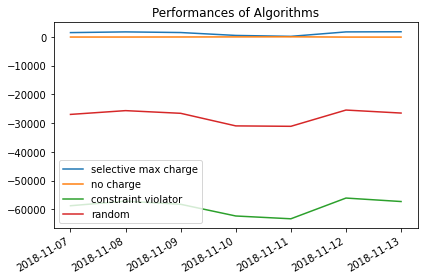

In [13]:
plt.title("Performances of Algorithms")
for col in heuristics_rewards.columns:
    plt.plot(heuristics_rewards[col], label=col)
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


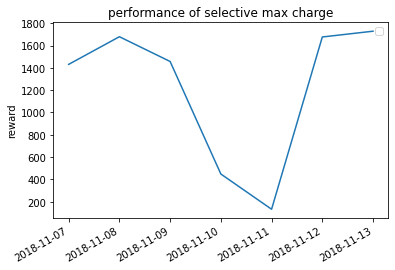

In [14]:
plt.title("performance of selective max charge")
plt.ylabel("reward")
plt.gcf().autofmt_xdate()
plt.legend()
plt.plot(heuristics_rewards['selective max charge'])

In [ ]:
# rewards

,selective max charge,no charge,constraint violator,random
dates,,,,
2018-11-07,1431.09619,-108.953704,-58726.430027,-27413.866995
2018-11-08,1678.92414,-108.568519,-57124.640764,-25530.657384
2018-11-09,1456.96505,-90.009259,-58225.706817,-26381.695055


In [16]:
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

from sustaingym.envs.evcharging.ev_charging import EVChargingEnv

In [18]:
train_env = EVChargingEnv('caltech', date_range, real_traces=True, sequential=False)
model = PPO('MultiInputPolicy', train_env, verbose=0)
rl_algo = RLAlgorithm(model)

untrained_rewards = collect_rewards(eval_env, [rl_algo])
display(untrained_rewards)

trained_rewards = {}
num_steps = 0
timesteps = 25_000

for _ in range(10):
    num_steps += timesteps
    model.learn(total_timesteps=timesteps)
    print("num timesteps: ", num_steps)
    trained_rewards[num_steps] = collect_rewards(eval_env, [rl_algo])
    display(trained_rewards[num_steps])

Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-27530.233596
2018-11-08,-26047.986816
2018-11-09,-26434.360625
2018-11-10,-30464.663646
2018-11-11,-31166.443874
2018-11-12,-25693.945429
2018-11-13,-27104.763353


num timesteps:  25000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-27210.780528
2018-11-08,-25424.398539
2018-11-09,-26485.943181
2018-11-10,-31014.131744
2018-11-11,-31517.118967
2018-11-12,-25670.840024
2018-11-13,-26585.789181


num timesteps:  50000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-26449.112370
2018-11-08,-25341.236395
2018-11-09,-26121.286323
2018-11-10,-30365.825143
2018-11-11,-30672.264089
2018-11-12,-25134.284622
2018-11-13,-26399.164671


num timesteps:  75000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-25719.429307
2018-11-08,-24756.350340
2018-11-09,-24815.185972
2018-11-10,-30420.338540
2018-11-11,-30227.014825
2018-11-12,-24717.078957
2018-11-13,-25790.296901


num timesteps:  100000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-26013.620269
2018-11-08,-24561.957645
2018-11-09,-24951.247720
2018-11-10,-29071.180484
2018-11-11,-29810.962631
2018-11-12,-24145.949549
2018-11-13,-25392.969390


num timesteps:  125000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-25224.688211
2018-11-08,-23488.130032
2018-11-09,-24138.268581
2018-11-10,-28810.354616
2018-11-11,-28950.493756
2018-11-12,-23583.235713
2018-11-13,-24259.598087


num timesteps:  150000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-23993.993815
2018-11-08,-23316.609759
2018-11-09,-23153.397749
2018-11-10,-27980.152506
2018-11-11,-27790.763374
2018-11-12,-22610.599186
2018-11-13,-24126.960454


num timesteps:  175000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-24117.083515
2018-11-08,-22425.575392
2018-11-09,-22824.705020
2018-11-10,-27736.258273
2018-11-11,-27214.135561
2018-11-12,-22662.364189
2018-11-13,-23150.691522


num timesteps:  200000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-23755.167101
2018-11-08,-22126.012924
2018-11-09,-23065.919416
2018-11-10,-26965.282889
2018-11-11,-27122.395302
2018-11-12,-22651.175911
2018-11-13,-22994.597284


num timesteps:  225000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-22891.897621
2018-11-08,-21833.364353
2018-11-09,-22377.590673
2018-11-10,-27010.515631
2018-11-11,-26565.737940
2018-11-12,-22017.638439
2018-11-13,-22575.232658


num timesteps:  250000
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-10 with 15 plug in events. 
Simulating day 2018-11-11 with 12 plug in events. 
Simulating day 2018-11-12 with 43 plug in events. 
Simulating day 2018-11-13 with 47 plug in events. 


,RL algorithm
dates,
2018-11-07,-22830.688014
2018-11-08,-21372.616705
2018-11-09,-22519.725936
2018-11-10,-27087.002432
2018-11-11,-26481.058160
2018-11-12,-21593.053190
2018-11-13,-21856.075044
